# Paper review: *"Learning to Remember Rare Events"*
## by L. Kaiser, O. Nachum, A. Roy, and S. Bengio

I've assumed three aims for this presentation:
1. To give you the gist of the paper: *"Learning to Remember Rare Events"* by Łukasz Kaiser, Ofir Nachum, Aurko Roy, and Samy Bengio;
2. To share with you a simple, didactic method of going through a block of code written in TensorFlow (utilizing `tf.eager`);
3. To show you how I (slightly) modified the code of `learning_to_remember_rare_events` and used it on a synthetic data set.

In [1]:
import numpy as np
np.random.seed(44)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-dark-palette')
mpl.style.use('seaborn-whitegrid')
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()
from memory import Memory

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
NUM_CLASSES = 2

KEY_DIM = 2
MEM_SZ = 2**8
VOCAB_SZ = 30

In [3]:
memory = Memory(key_dim=KEY_DIM, memory_size=MEM_SZ, vocab_size=VOCAB_SZ, choose_k=8)

The crucial part of the whole `learning_to_remember_rare_events` implementation is the `Memory.query` method:
```python
def query(self, query_vec, intended_output, use_recent_idx=True):
```
with the following description:

In [4]:
print(Memory.query.__doc__)

Queries memory for nearest neighbor.

    Args:
      query_vec: A batch of vectors to query (embedding of input to model).
      intended_output: The values that would be the correct output of the
        memory.
      use_recent_idx: Whether to always insert at least one instance of a
        correct memory fetch.

    Returns:
      A tuple (result, mask, teacher_loss).
      result: The result of the memory look up.
      mask: The affinity of the query to the result.
      teacher_loss: The loss for training the memory module.
    


In [5]:
def calc_angle_deg(x):
    return np.rad2deg(np.arctan2(x[:, 1], x[:, 0]))


def plot_scatter(array, y, ax):
    colors = {0: 'blue', 1: 'red'}
    for label in [0, 1]:
        rows = (y==label)
        ax.scatter(array[rows, 0], array[rows, 1], c=colors[label], cmap='winter', label=str(label))  
    ax.legend(loc='lower right')

We will generate a synthetic data set which we'll use to initialize the attributes of the `Memory` class, so that we'll be able to go through the `Memory.query` method.

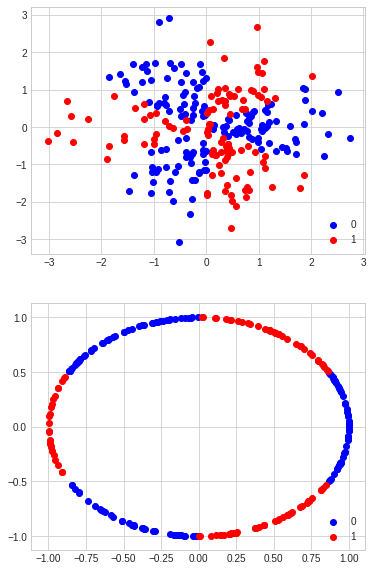

In [6]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]
sample = np.random.multivariate_normal(mean, cov, size=MEM_SZ)

angle = calc_angle_deg(sample)
y = np.where(np.round(angle / 60) % 2, 1, 0)

norm = np.linalg.norm(sample, axis=1)
normed_sample = sample / np.expand_dims(norm, 1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))
plot_scatter(sample, y, ax1)
plot_scatter(normed_sample, y, ax2)

The following attributes are (actually) non-trainable variables, and to carry out our experiments, we'll initialize them with the synthetic data generated a second ago:

In [7]:
memory.mem_keys = tfe.Variable(
    normed_sample,
    dtype=tf.float32,
)
memory.mem_vals = tfe.Variable(
    y,
    dtype=tf.int32,
)

These attributes are the core of the `Memory` class, and they are modified in the `Memory.query` method. There's also the `mem_age` attribute, which stores the age of the elements in the memory, but for the sake of simplicity, we'll simply ignore it.

There is also one trainable attribute that's not mentioned in the paper, which we'll also need to set up:

In [8]:
memory.query_proj = tfe.Variable(
    np.eye(KEY_DIM),
    dtype=tf.float32,
)

It's used in the `Memory.query` method to project the `query_vec`:

```python
def query(self, query_vec, intended_output, use_recent_idx=True):
    ...
    query_vec = tf.matmul(query_vec, self.query_proj)
    ...
```

We will now generate **four** observations which we'll pass to `Memory.query` as the `query_vec` argument:

In [9]:
eps = 0.05
points = np.array([
    [eps, 1],    # borderline positive
    [2*eps, 1],  # more positive
    [-eps, 1],   # borderline negative
    [-2*eps, 1], # more negative
])

print('The angles are: {}'.format(calc_angle_deg(points)))

query_vec = tf.constant(
    points,
    dtype=tf.float32
)

The angles are: [87.13759477 84.28940686 92.86240523 95.71059314]


So, the first two observations are less than 90 degrees, and thus should be identified as class "1". The two subsequent observations are above the 90 degrees threshold, and are thus of class "0".

And indeed, that's what we get from `Memory.query`:

In [10]:
result, mask, teacher_loss = memory.query(query_vec, intended_output=None, use_recent_idx=False)

In [11]:
print('Results: {}'.format(result.numpy()))

Results: [1 1 0 0]
As a reminder, the angles were: [87.13759477 84.28940686 92.86240523 95.71059314]


To disect the `Memory.query` method, we'll create a variable called `self` which will be our `memory` object.

It's not pretty, but it'll help us to actually run the body of the method line by line in the notebook, **exactly** as it is in the original implementation.

In [12]:
self = memory

intended_output = None

use_recent_idx = False

OK, so now that we know that we get the right results, let's take a peek inside the method to better understand how it works.

We will often take a look at the first four elements of a matrix, and it pays off to define the following function:

In [13]:
def print_tensor(tensor):
    array = tensor.numpy()
    if len(array.shape)==1:
        print(array)
    else:
        print(array[:, :4])

```python
def query(self, query_vec, intended_output, use_recent_idx=True):
```

In [14]:
batch_size = tf.shape(query_vec)[0]
output_given = intended_output is not None

# prepare query for memory lookup
query_vec = tf.matmul(query_vec, self.query_proj)
normalized_query = tf.nn.l2_normalize(query_vec, dim=1)

# get a small set of idxs to compute nearest neighbor queries on
# (without propagating gradients)
hint_pool_idxs = self.get_hint_pool_idxs(normalized_query)

In [15]:
print_tensor(hint_pool_idxs)

[[186  73 117 123]
 [123 169 186  73]
 [ 59  43 239  55]
 [  4 139  55 239]]


In [16]:
print(calc_angle_deg(normed_sample[[186, 73,  117]]))

[88.38441164 88.88515412 90.1270974 ]


What follows in the original code is an `if`-clause:
```python
if output_given and use_recent_idx:
    ...
```
which we won't enter, since both `output_given` and `use_recent_idx` are `False`.

In [17]:
choose_k = tf.shape(hint_pool_idxs)[1]

Now, we'll calculate similarities of the `query_vec` with the selected memory keys, `my_mem_keys`, to later choose k most similar keys, and their corresponding values.

In [18]:
with tf.device(self.var_cache_device):
    # create small memory and look up with gradients
    my_mem_keys = tf.stop_gradient(tf.gather(self.mem_keys, hint_pool_idxs,
                                             name='my_mem_keys_gather'))
    similarities = tf.matmul(tf.expand_dims(normalized_query, 1),
                             my_mem_keys, adjoint_b=True, name='batch_mmul')
    hint_pool_sims = tf.squeeze(similarities, [1], name='hint_pool_sims')
    hint_pool_mem_vals = tf.gather(self.mem_vals, hint_pool_idxs,
                                   name='hint_pool_mem_vals')

In [19]:
print_tensor(hint_pool_sims)

[[0.99976325 0.9995349  0.99863917 0.9983218 ]
 [0.999966   0.9998275  0.99744695 0.9967848 ]
 [0.99999464 0.9999938  0.9998748  0.9998624 ]
 [0.9999834  0.9998056  0.99945146 0.99942577]]


In [20]:
print_tensor(hint_pool_mem_vals)

[[1 1 0 1]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]]


Before returning the final results, we also calculate a "softmax mask" which can be used to "(...) provide a signal about confidence of the memory."

In [21]:
# Calculate softmax mask on the top-k if requested.
# Softmax temperature. Say we have K elements at dist x and one at (x+a).
# Softmax of the last is e^tm(x+a)/Ke^tm*x + e^tm(x+a) = e^tm*a/K+e^tm*a.
# To make that 20% we'd need to have e^tm*a ~= 0.2K, so tm = log(0.2K)/a.
softmax_temp = max(1.0, np.log(0.2 * self.choose_k) / self.alpha)
mask = tf.nn.softmax(hint_pool_sims[:, :choose_k - 1] * softmax_temp)

# prepare returned values
nearest_neighbor = tf.to_int32(
    tf.argmax(hint_pool_sims[:, :choose_k - 1], 1))

no_teacher_idxs = tf.gather(
    tf.reshape(hint_pool_idxs, [-1]),
    nearest_neighbor + choose_k * tf.range(batch_size))

with tf.device(self.var_cache_device):
    result = tf.gather(self.mem_vals, tf.reshape(no_teacher_idxs, [-1]))

In [22]:
print_tensor(mask)

[[0.14423737 0.14408271 0.1434774  0.14326347]
 [0.14485371 0.14475946 0.14314878 0.14270401]
 [0.14331245 0.1433119  0.14323178 0.14322338]
 [0.1433727  0.14325297 0.1430147  0.14299746]]


In [23]:
print_tensor(no_teacher_idxs)

[186 123  59   4]


Because the `result` is a "hard" prediction (0, or 1 in this case), I've used the `mask` variable to produce a "softned" prediction, i.e. estimated probabilities of class 0 and 1.

In [24]:
probs = tf.map_fn(
    lambda cls_: tf.reduce_sum(
        tf.where(
            tf.equal(hint_pool_mem_vals[:, :choose_k - 1], cls_),
            mask,
            tf.zeros_like(mask),
        ),
        axis=1
    ),
    tf.range(NUM_CLASSES),
    dtype=tf.float32,
)

probs = tf.transpose(probs)

print(probs.numpy())

[[0.42559132 0.57440865]
 [0.14138824 0.85861176]
 [0.85829705 0.14170301]
 [1.         0.        ]]


At this point in the code, if `output_given` was `False`, we are ready to get to this function's `return` statement:

```python
if not output_given:
    teacher_loss = None
    return result, mask, teacher_loss
```

Obviously, we're not running this in a notebook cell, but you're welcome to try it yourself ;)

So, what are those returned values? Let's take a look:

In [25]:
print_tensor(result)

[1 1 0 0]


[[0.14423737 0.14408271 0.1434774  0.14326347]
 [0.14485371 0.14475946 0.14314878 0.14270401]
 [0.14331245 0.1433119  0.14323178 0.14322338]
 [0.1433727  0.14325297 0.1430147  0.14299746]]


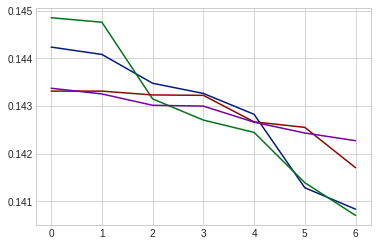

In [26]:
print_tensor(mask)

for m in mask:
    plt.plot(m)

How is the memory updated, if `output_given` is `True`?

Let's say have a query $q$ with a corresponding value $v$.


![](img/memory_update.png)

Where $K$ is the matrix of keys, $V$ is the vector of values, and $A$ is the vector of ages. The memory is a triple: $\mathcal{M} = (K, V, A)$. 

Additionally, $n_1$ is the index of the first, matching key, $k_1$, whereas $n_b$ is the index of the closest, non-matching key, $k_b$. If $K[n_1]$ doesn't match $v$, the closest positive index and key are denoted by $n_p$, and $k_p$.

The Loss depends on whether $V[n_1] == v$, but notice **one important thing**: the gradients are propagated through $q$ based ONLY on how $q$ relates to two keys ($k_1$ and $k_b$, or $k_b$ and $k_p$). 

Now, let's go through this procedure once again, but this time let's provide the `intended_output`.

In [27]:
intended_output = tf.constant(
    [1, 1, 0, 0],
    dtype=tf.int32,
)

use_recent_idx = True

In [28]:
batch_size = tf.shape(query_vec)[0]
output_given = intended_output is not None

# prepare query for memory lookup
query_vec = tf.matmul(query_vec, self.query_proj)
normalized_query = tf.nn.l2_normalize(query_vec, dim=1)

hint_pool_idxs = self.get_hint_pool_idxs(normalized_query)

In [29]:
print_tensor(hint_pool_idxs)

[[186  73 117 123]
 [123 169 186  73]
 [ 59  43 239  55]
 [  4 139  55 239]]


In [30]:
if output_given and use_recent_idx:  # add at least one correct memory
    most_recent_hint_idx = tf.gather(self.recent_idx, intended_output)
    hint_pool_idxs = tf.concat(
        axis=1,
        values=[hint_pool_idxs, tf.expand_dims(most_recent_hint_idx, 1)])
    
choose_k = tf.shape(hint_pool_idxs)[1]

In [31]:
print_tensor(hint_pool_idxs)

[[186  73 117 123]
 [123 169 186  73]
 [ 59  43 239  55]
 [  4 139  55 239]]


In [32]:
print_tensor(most_recent_hint_idx)

[0 0 0 0]


In [33]:
print_tensor(self.recent_idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
with tf.device(self.var_cache_device):
    # create small memory and look up with gradients
    my_mem_keys = tf.stop_gradient(tf.gather(self.mem_keys, hint_pool_idxs,
                                             name='my_mem_keys_gather'))
    similarities = tf.matmul(tf.expand_dims(normalized_query, 1),
                             my_mem_keys, adjoint_b=True, name='batch_mmul')
    hint_pool_sims = tf.squeeze(similarities, [1], name='hint_pool_sims')
    hint_pool_mem_vals = tf.gather(self.mem_vals, hint_pool_idxs,
                                   name='hint_pool_mem_vals')
    
# Calculate softmax mask on the top-k if requested.
# Softmax temperature. Say we have K elements at dist x and one at (x+a).
# Softmax of the last is e^tm(x+a)/Ke^tm*x + e^tm(x+a) = e^tm*a/K+e^tm*a.
# To make that 20% we'd need to have e^tm*a ~= 0.2K, so tm = log(0.2K)/a.
softmax_temp = max(1.0, np.log(0.2 * self.choose_k) / self.alpha)
mask = tf.nn.softmax(hint_pool_sims[:, :choose_k - 1] * softmax_temp)

# prepare returned values
nearest_neighbor = tf.to_int32(
    tf.argmax(hint_pool_sims[:, :choose_k - 1], 1))

no_teacher_idxs = tf.gather(
    tf.reshape(hint_pool_idxs, [-1]),
    nearest_neighbor + choose_k * tf.range(batch_size))

with tf.device(self.var_cache_device):
    result = tf.gather(self.mem_vals, tf.reshape(no_teacher_idxs, [-1]))

In [35]:
# prepare hints from the teacher on hint pool
teacher_hints = tf.to_float(
    tf.abs(tf.expand_dims(intended_output, 1) - hint_pool_mem_vals))

In [36]:
print_tensor(teacher_hints)

[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [37]:
teacher_hints = 1.0 - tf.minimum(1.0, teacher_hints)

In [38]:
print_tensor(teacher_hints)

[[1. 1. 0. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [39]:
teacher_vals, teacher_hint_idxs = tf.nn.top_k(
    hint_pool_sims * teacher_hints, k=1)
neg_teacher_vals, _ = tf.nn.top_k(
    hint_pool_sims * (1 - teacher_hints), k=1)

In [40]:
print_tensor(teacher_vals)

[[0.99976325]
 [0.999966  ]
 [0.99999464]
 [0.9999834 ]]


In [41]:
print_tensor(neg_teacher_vals)

[[0.99863917]
 [0.994814  ]
 [0.9975917 ]
 [0.        ]]


In [42]:
# bring back idxs to full memory
teacher_idxs = tf.gather(
    tf.reshape(hint_pool_idxs, [-1]),
    teacher_hint_idxs[:, 0] + choose_k * tf.range(batch_size))

In [43]:
print_tensor(teacher_idxs)

[186 123  59   4]


In [44]:
# zero-out teacher_vals if there are no hints
teacher_vals *= (
    1 - tf.to_float(tf.equal(0.0, tf.reduce_sum(teacher_hints, 1))))

# we'll determine whether to do an update to memory based on whether
# memory was queried correctly
sliced_hints = tf.slice(teacher_hints, [0, 0], [-1, self.correct_in_top])
incorrect_memory_lookup = tf.equal(0.0, tf.reduce_sum(sliced_hints, 1))

# loss based on triplet loss
teacher_loss = (tf.nn.relu(neg_teacher_vals - teacher_vals + self.alpha)
                - self.alpha)

# prepare memory updates
update_keys = normalized_query
update_vals = intended_output

fetched_idxs = teacher_idxs  # correctly fetched from memory
with tf.device(self.var_cache_device):
    fetched_keys = tf.gather(self.mem_keys, fetched_idxs, name='fetched_keys')
    fetched_vals = tf.gather(self.mem_vals, fetched_idxs, name='fetched_vals')

# do memory updates here
fetched_keys_upd = update_keys + fetched_keys  # Momentum-like update
fetched_keys_upd = tf.nn.l2_normalize(fetched_keys_upd, dim=1)
# Randomize age a bit, e.g., to select different ones in parallel workers.
mem_age_with_noise = self.mem_age + tf.random_uniform(
    [self.memory_size], - self.age_noise, self.age_noise)

_, oldest_idxs = tf.nn.top_k(mem_age_with_noise, k=batch_size, sorted=False)

with tf.control_dependencies([result]):
    upd_idxs = tf.where(incorrect_memory_lookup,
                        oldest_idxs,
                        fetched_idxs)
    upd_keys = tf.where(incorrect_memory_lookup,
                        update_keys,
                        fetched_keys_upd)
    upd_vals = tf.where(incorrect_memory_lookup,
                        update_vals,
                        fetched_vals)

In [45]:
 def make_update_op():
    mem_age_incr = self.mem_age.assign_add(tf.ones([self.memory_size],
                                                   dtype=tf.float32))
    with tf.control_dependencies([mem_age_incr]):
        mem_age_upd = tf.scatter_update(
            self.mem_age, upd_idxs, tf.zeros([batch_size], dtype=tf.float32))

    mem_key_upd = tf.scatter_update(
        self.mem_keys, upd_idxs, upd_keys)
    mem_val_upd = tf.scatter_update(
        self.mem_vals, upd_idxs, upd_vals)

    if use_recent_idx:
        recent_idx_upd = tf.scatter_update(
            self.recent_idx, intended_output, upd_idxs)
    else:
        recent_idx_upd = tf.group()

    return tf.group(mem_age_upd, mem_key_upd, mem_val_upd, recent_idx_upd)

In [46]:
update_op = tf.cond(self.update_memory, make_update_op, tf.no_op)

with tf.control_dependencies([update_op]):
    result = tf.identity(result)
    mask = tf.identity(mask)
    teacher_loss = tf.identity(teacher_loss)

What follows is a `return` statement:
```python
return result, mask, tf.reduce_mean(teacher_loss)
```
which ends the `Memory.query` method.